<a href="https://colab.research.google.com/github/bubka42/marrakech/blob/main/Marrackech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from typing import List, Tuple, Dict, Set, TypeVar
from collections import namedtuple
from enum import Enum
import time

In [2]:
# test
a = np.array([range(7) for i in range(7)])
print(a[4,5])
type(a)
Pp = namedtuple('Content', ['colour', 'rug'])
type(Pp)
a = (0, 1)
b = (2, 3)
c = (a, b)
w, x, y, z = *a, *b
print(w, x, y, z)
Tt = Tuple[int, int]
ll = [[(col, row) for row in range(3)] for col in range(5)]
print(ll[3][2])
print(tuple(map(sum, zip(a, b))))
ss = {1, 2, 3}
ss.remove(2)
print(ss)
grid = np.mgrid[0:6:7j, 0:6:7j].reshape(2, -1).T
#print(grid)
#rect = plt.Rectangle([0, 0] - [1, 1], 1, 1, 0, facecolor='white', edgecolor='black')
plt.draw()
plt.show()

5
0 1 2 3
(3, 2)
(2, 4)
{1, 3}


<Figure size 432x288 with 0 Axes>

In [3]:
# custom types

class Colour(Enum):
    NONE = 0
    RED = 1
    BLUE = 2
    YELLOW = 3
    GREEN = 4

class Direction(Enum):
    RIGHT = 3
    DOWN = 6
    LEFT = 9
    UP = 12

Cell = Tuple[int, int]
Rug = Tuple[Cell, Cell]

Assam: namedtuple = namedtuple('Assam', ['cell', 'direction'])

T: TypeVar = TypeVar('T')
Grid = List[List[T]]
CellState: namedtuple = namedtuple('CellState', ['colour', 'rug'])
Board = Grid[CellState]

Turn: namedtuple = namedtuple('Turn', ['new_direction', 'roll', 'rug', 'colour'])
Transcript = List[Turn]

In [4]:
class AssamTooFarError(Exception):
    pass

class AssamInWayError(Exception):
    pass

class OutOfBoardError(Exception):
    pass

class InvalidTurnError(Exception):
    pass

class RugAlreadyThereError(Exception):
    pass

class NotARugError(Exception):
    pass

class AboutTurnError(Exception):
    pass

class SizeNotOddError(Exception):
    pass

class InvalidRollError(Exception):
    pass

class CellNotConnectedError(Exception):
    pass

In [5]:
class MarrackechPlayer:
    NUM_RUGS: int = 15
    START_MONEY: int = 30

    def __init__(self, player_colour: Colour, num_rugs = NUM_RUGS, start_money = START_MONEY):
        self.rugs: list[Rug] = [Marrakech.NULL_RUG for round in range(num_rugs)]
        self.money: int = start_money
        self.colour = player_colour

    def place_rug(self, board: Board, assam: Cell, target: Rug):
        ____
        


In [105]:
class Marrakech:
    SIZE: int = 7
    START_ASSAM: Assam = Assam(cell = (3, 3), direction = Direction.UP)
    NULL_CELL: Cell = (-1, -1)
    NULL_RUG: Rug = (NULL_CELL, NULL_CELL)
    NUM_PLAYERS: int = 2
    COLOUR_MAP = {
        Colour.RED: 'peachpuff',
        Colour.BLUE: 'lightskyblue',
        Colour.YELLOW: 'lemonchiffron',
        Colour.GREEN : 'springgreen'
    }
    EDGE_MAP = {
        Colour.RED: 'red',
        Colour.BLUE: 'blue',
        Colour.YELLOW: 'yellow',
        Colour.GREEN : 'green'
    }

    def __init__(self, size: int = SIZE, start_assam: Assam = START_ASSAM, num_players: int = NUM_PLAYERS):
        if not size % 2:
            raise SizeNotOddError
        else:
            self.size: int = size
            self.board: Board = [[CellState(colour = Colour.NONE, rug = Marrakech.NULL_RUG) for
                                  row in range(self.size)] for col in range(self.size)]
            self.start_assam: Assam = start_assam
            self.assam: Assam = self.start_assam
            self.num_players: int = num_players
            self.fig, self.ax = plt.subplots()
            plt.xlim([0, self.size])
            plt.ylim([0, self.size])
            plt.grid(True)
            plt.gca().set_aspect("equal")

    def reset(self) -> None:
        self.board = [[CellState(colour = Colour.NONE, rug = Marrakech.NULL_RUG) for
                       row in range(self.size)] for col in range(self.size)]
        self.assam = self.start_assam
        self.fig, self.ax = plt.subplots()
        plt.xlim([0, self.size])
        plt.ylim([0, self.size])
        plt.grid(True)
        plt.gca().set_aspect("equal")
    
    def get_state(self, cell: Cell) -> CellState:
        col, row = cell
        return self.board[col][row]

    def is_empty(self, cell: Cell) -> bool:
        return self.get_state(cell).colour == Colour.NONE

    def distance(self, cell1: Cell, cell2: Cell = NULL_CELL) -> int:
        if cell2 == Marrakech.NULL_CELL:
            cell2 = self.assam.cell
        col1, row1, col2, row2 = *cell1, *cell2
        return np.abs(col1 - col2) + np.abs(row1 - row2)

    def share_rug(self, cell1: Cell, cell2: Cell) -> bool:
        if self.is_empty(cell1) or self.is_empty(cell2):
            return False
        else:
            return set(self.get_state(cell1).rug) == set(self.get_state(cell2).rug)

    def set_state(self, cell: Cell, colour: Colour, rug: Rug):
        col, row = cell
        self.board[col][row] = CellState(colour, rug)

    def render_rug(self, rug: Rug, colour: Colour) -> None:
        cell1, cell2 = rug
        col1, row1, col2, row2 = *cell1, *cell2
        anchor = (min(col1, col2), min(row1, row2))
        rug_width = np.abs(col2 - col1) + 1
        rug_height = np.abs(row2 - row1) + 1
        rug_colour = Marrakech.COLOUR_MAP[colour]
        rug_edge = Marrakech.EDGE_MAP[colour]
        rug_patch = mpatches.Rectangle(anchor, width = rug_width, height = rug_height,
                                       facecolor = rug_colour, edgecolor = rug_edge, linewidth = 3)
        self.ax.add_patch(rug_patch)

    def put_rug(self, rug: Rug, colour: Colour) -> None:
        cell1, cell2 = rug
        if not self.distance(cell1, cell2) == 1:
            raise NotARugError
        elif self.assam.cell in rug:
            raise AssamInWayError
        elif self.distance(cell1) + self.distance(cell2) > 3:
            raise AssamTooFarError
        elif self.share_rug(cell1, cell2):
            raise RugAlreadyThereError
        else:
            self.set_state(cell1, colour, rug)
            self.set_state(cell2, colour, rug)
            self.render_rug(rug, colour)

    def face_assam(self, new_direction: Direction) -> None:
        if np.abs(self.assam.direction.value - new_direction.value) == 6:
            raise AboutTurnError
        else:
            current_cell = self.assam.cell
            self.assam = Assam(cell = current_cell, direction = new_direction)

    def next_assam(self) -> Assam:
        shift_map: Dict[Direction, Cell] = {
            Direction.RIGHT: (1, 0),
            Direction.DOWN: (0, -1),
            Direction.LEFT: (-1, 0),
            Direction.UP: (0, 1)
        }
        border_map: Dict[Cell, Tuple[Cell, Direction]] = {
            (0, -1): ((0, 0), Direction.RIGHT),
            (-1, 0): ((0, 0), Direction.UP),
            (self.size - 1, self.size): ((self.size - 1, self.size - 1), Direction.LEFT),
            (self.size, self.size - 1): ((self.size - 1, self.size - 1), Direction.DOWN)
        }
        for col in range(1, self.size):
            if col % 2:
                border_map[(col, self.size)] = ((col - 1, self.size - 1), Direction.DOWN)
                border_map[(col - 1, self.size)] = ((col, self.size - 1), Direction.DOWN)
            else:
                border_map[(col, -1)] = ((col - 1, 0), Direction.UP)
                border_map[(col - 1, -1)] = ((col, 0), Direction.UP)
        for row in range(1, self.size):
            if row % 2:
                border_map[(self.size, row)] = ((self.size - 1, row - 1), Direction.LEFT)
                border_map[(self.size, row - 1)] = ((self.size - 1, row), Direction.LEFT)
            else:
                border_map[(-1, row)] = ((0, row - 1), Direction.RIGHT)
                border_map[(-1, row - 1)] = ((0, row), Direction.RIGHT)
        next_cell = tuple(map(sum, zip(self.assam.cell, shift_map[self.assam.direction])))
        col, row = next_cell
        border = (-1, self.size)
        if col in border or row in border:
            new_cell, new_direction = border_map[next_cell]
            return Assam(new_cell, new_direction)
        else:
            return Assam(next_cell, self.assam.direction)

    def move_assam(self, roll: int) -> None:
        if not roll in range(1, 5):
            raise InvalidRollError
        else:
            for slipper in range(roll):
                self.assam = self.next_assam()

    def connected_helper(self, cell: Cell, marked: Set[Cell]) -> None:
        col, row = cell
        colour: Colour = self.get_state(cell).colour
        neighbours = {(col - 1, row), (col + 1, row), (col, row - 1), (col, row + 1)}
        for neighbour in neighbours:
            ncol, nrow = neighbour
            border = (-1, self.size)
            if ncol in border or nrow in border:
                neighbours.remove(neighbour)
        for neighbour in neighbours:
            if not neighbour in marked and self.get_state(neighbour).colour == colour:
                marked.add(neighbour)
                self.connected_helper(neighbour, marked)

    def connected(self, cell: Cell) -> Set[Cell]:
        if self.is_empty(cell):
            raise CellNotConnectedError
        else:
            colour: Colour = self.get_state(cell).colour
            marked: Set[Cell] = {cell}
            self.connected_helper(cell, marked)
            return marked

    def penalty(self, cell: Cell) -> int:
        return len(self.connected(cell))

    def execute_turn(self, turn: Turn) -> None:
        self.face_assam(turn.new_direction)
        self.move_assam(turn.roll)
        self.put_rug(turn.rug, turn.colour)

    def render_assam(self) -> None:
        col_correct = 0.03
        col_center, row_center = 0.5 + col_correct, 0.5
        face_offset = 0.13
        face_map: Dict[Direction, Tuple(float, float, float, float)] = {
            Direction.RIGHT: (col_center + face_offset, row_center, 300.0, 60.0),
            Direction.DOWN: (col_center, row_center - face_offset, 210.0, 330.0),
            Direction.LEFT: (col_center - face_offset, row_center, 120.0, 240.0),
            Direction.UP: (col_center, row_center + face_offset, 150.0, 30.0)
        }
        col, row = self.assam.cell
        assam_patch = mpatches.Circle((col + col_center, row + row_center), radius = 0.2, color = 'black')
        self.ax.add_patch(assam_patch)
        col_offset, row_offset, start_angle, end_angle = face_map[self.assam.direction]
        face_patch = mpatches.Arc((col + col_offset, row + row_offset), width = 0.5, height = 0.5,
                                  theta1 = start_angle, theta2 = end_angle)
        self.ax.add_patch(face_patch)

    def playback(self, transcript: Transcript) -> None:
        for turn in transcript:
            self.execute_turn(turn)
        self.render_assam()

    def step_playback(self, transcript: Transcript) -> None:
        for stop in range(1, len(transcript)):
            self.playback(transcript[:stop])
            self.reset()
        self.playback(transcript)



In [7]:
# test

mm = Marrakech()
rug = ((3, 4), (3, 5))
mm.put_rug(rug, Colour.BLUE)
rug2 = ((3, 4), (4, 4))
mm.put_rug(rug2, Colour.RED)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.RIGHT)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.UP)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.DOWN)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.LEFT)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.DOWN)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.DOWN)
mm.move_assam(4)
print(mm.assam)
mm.face_assam(Direction.UP)
mm.move_assam(1)
print(mm.assam)
mm.face_assam(Direction.LEFT)
mm.move_assam(2)
print(mm.assam)
mm.face_assam(Direction.DOWN)
mm.move_assam(3)
print(mm.assam)
mm.face_assam(Direction.LEFT)
mm.move_assam(4)
print(mm.assam)

Assam(cell=(2, 6), direction=<Direction.DOWN: 6>)
Assam(cell=(6, 6), direction=<Direction.RIGHT: 3>)
Assam(cell=(3, 6), direction=<Direction.LEFT: 9>)
Assam(cell=(3, 2), direction=<Direction.DOWN: 6>)
Assam(cell=(0, 1), direction=<Direction.RIGHT: 3>)
Assam(cell=(2, 0), direction=<Direction.RIGHT: 3>)
Assam(cell=(1, 3), direction=<Direction.UP: 12>)
Assam(cell=(1, 4), direction=<Direction.UP: 12>)
Assam(cell=(0, 3), direction=<Direction.RIGHT: 3>)
Assam(cell=(0, 0), direction=<Direction.DOWN: 6>)
Assam(cell=(0, 3), direction=<Direction.UP: 12>)


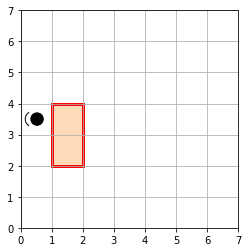

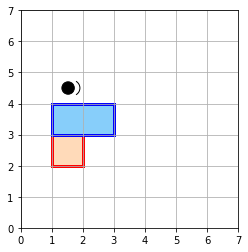

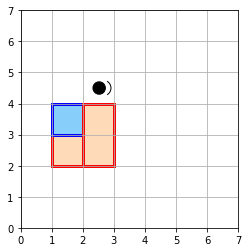

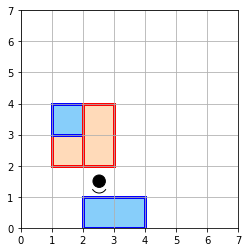

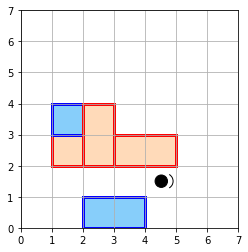

In [106]:
mm = Marrakech()
cr = Colour.RED
cb = Colour.BLUE
du = Direction.UP
dd = Direction.DOWN
dl = Direction.LEFT
dr = Direction.RIGHT
t1 = Turn(dl, 3, ((1,2), (1,3)), cr)
t2 = Turn(dl, 2, ((1,3), (2,3)), cb)
t3 = Turn(dr, 1, ((2,2), (2,3)), cr)
t4 = Turn(dd, 3, ((2,0), (3,0)), cb)
t5 = Turn(dr, 2, ((3,2), (4,2)), cr)
tt = [t1, t2, t3, t4, t5]
mm.step_playback(tt)
#print(mm.penalty((2,2)), mm.penalty((1,3)))

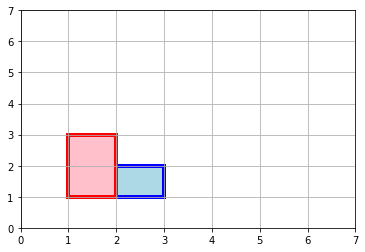

In [54]:
fig, ax = plt.subplots()
plt.xlim([0, 7])
plt.ylim([0, 7])
plt.grid(True)
rug1 = mpatches.Rectangle((1, 1), width=2, height=1, facecolor='lightblue', edgecolor='blue', linewidth=4)
ax.add_patch(rug1)
rug2 = mpatches.Rectangle((1, 1), width=1, height=2, facecolor='pink', edgecolor='red', linewidth=4)
ax.add_patch(rug2)

